[UMAP](https://umap-learn.readthedocs.io/en/latest/) is a powerful dimensionality reduction tool which NVIDIA recently ported to GPUs with a python interface.  In this notebook we will demostrate basic usage, plotting, and timing comparisons between the CUDA (GPU) version of UMAP and the original CPU version of UMAP 

In [1]:
!pip install umap-learn

In [2]:
import os
os.getenv("JUPYTER_TOKEN")

'12a75b6c5096535122617e0bd79ca35e'

In [3]:
!pip install seaborn
!pip install matplotlib


In [4]:
!nvidia-smi

Thu May 20 06:40:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   25C    P8     5W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
import pandas as pd
import numpy as np

# CPU UMAP
import umap

# libraries for scoring/clustering
from sklearn.manifold import trustworthiness

# GPU UMAP
import cudf
from cuml.manifold.umap import UMAP as cumlUMAP

# plotting
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

try:
    import matplotlib as mpl
except ModuleNotFoundError:
    os.system('conda install -y matplotlib')
    import matplotlib as mpl
    import matplotlib.pyplot as plt
     
%matplotlib inline
import matplotlib.pyplot as plt
# try:
#     import cuxfilter
# except ModuleNotFoundError:
#     os.system('conda install -c rapidsai -y cuxfilter')   
import cuxfilter
from cuxfilter.charts import scatter, bokeh
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.assets.custom_tiles import get_provider, Vendors
from bokeh.palettes import Spectral, Magma, Inferno, Plasma, Viridis, Cividis, Category20c
import csv


In [6]:
!conda list

# packages in environment at /opt/conda/envs/rapids:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
abseil-cpp                20210324.0           h9c3ff4c_0    conda-forge
aiohttp                   3.7.4            py37h5e8e339_0    conda-forge
alsa-lib                  1.2.3                h516909a_0    conda-forge
anyio                     2.2.0            py37h89c1867_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py37h5e8e339_2    conda-forge
arrow-cpp                 1.0.1           py37h363ccdf_36_cuda    conda-forge
arrow-cpp-proc            3.0.0                      cuda    conda-forge
async-timeout             3.0.1                   py_1000    conda-forge
async_generator           1.10                       py_0    conda-for

We are going to work with the [fashion mnist](https://github.com/zalandoresearch/fashion-mnist) data set.  This is a dataset consisting of 70,000 28x28 grayscale images of clothing.

In [7]:
if not os.path.exists('fashion_mnist'):
    !git clone https://github.com/zalandoresearch/fashion-mnist.git fashion_mnist

In [8]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [9]:
train, train_labels = load_mnist('fashion_mnist/data/fashion', kind='train')
test, test_labels = load_mnist('fashion_mnist/data/fashion', kind='t10k')
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.array(np.hstack([train_labels, test_labels]))

There are 60000 training images and 10000 test images

In [10]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"

'Train shape: (60000, 784) and Test Shape: (10000, 784)'

In [11]:
train[0].shape

(784,)

As mentioned previously, each row in the train matrix is an image

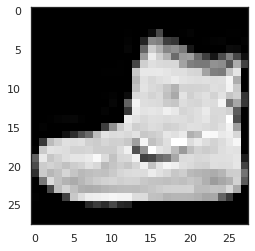

In [12]:
# display a Nike? sneaker
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

There is cost with moving data between host memory and device memory (GPU memory) and we will include that core when comparing speeds

In [13]:
%%time
gdf = cudf.DataFrame()
for i in range(data.shape[1]):
    gdf['fea%d'%i] = data[:,i]

CPU times: user 3.22 s, sys: 2.37 s, total: 5.6 s
Wall time: 7.61 s


In [14]:
data_dir = '../../data/umap/'
if not os.path.exists(data_dir):
    print('creating umap data directory')
    os.system('mkdir ../../data/umap')

In [15]:
!ls ../../data/umap

embedding  g_embedding


In [16]:
%%timeit
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)
g_embedding_plt = g_embedding 
# print(g_embedding.head())
# g_embedding = g_embedding.to_csv

if not os.path.exists('../../data/umap/g_embedding'):
    
    g_embedding.to_csv(r'../../data/umap/g_embedding', index=False)
    print('Saved g_embedding file as .csv')
#     with open(data_dir , g_embedding) as csvFile: #EDIT - because comment.
#         writer = csv.writer(csvFile)  


2 s ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
!ls ../../data/umap

embedding  g_embedding


`gdf` is a GPU backed dataframe -- all the data is stored in the device memory of the GPU.  With the data converted, we can apply the `cumlUMAP` the same inputs as we do for the standard UMAP.  Additionally, it should be noted that within cuml, [FAISS] https://github.com/facebookresearch/faiss) is used for extremely fast kNN and it's limited to single precision.  `cumlUMAP` will automatically downcast to `float32` when needed.

In [18]:
%%timeit
embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)
embedding_plt = embedding
# print(embedding.head())
#embedding = embedding.to_csv

if not os.path.exists('../../data/umap/embedding'):
    
    embedding.to_csv(r'../../data/umap/embedding', index=False)
    print('Saved embedding file as .csv')
#     with open(data_dir , g_embedding) as csvFile: #EDIT - because comment.
#         writer = csv.writer(csvFile) 


2 s ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
!ls ../../data/umap

embedding  g_embedding


Compute Runtimes of UMAP training (lower is better):
- cumlUMAP (GPU): 10.5
- UMAP (CPU): 100 seconds

cumlMAP is ~9.5x speed up over UMAP CPU.  We should also qualitatively compare output accuracy.  We can do this easily by plotting the embeddings and noting simlarites in the plot

In [20]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

In [21]:
#Needs to be redone because of timeit loses our variables sometimes
g_embedding_filepath = '../../data/umap/g_embedding'
embedding_filepath = '../../data/umap/embedding'

embedding = cudf.read_csv(embedding_filepath)
g_embedding = cudf.read_csv(g_embedding_filepath)

Just as the original author of UMAP, Leland McInnes, states in the [UMAP docs](https://umap-learn.readthedocs.io/en/latest/supervised.html), we can plot the results and show the separation between the various classes defined above.

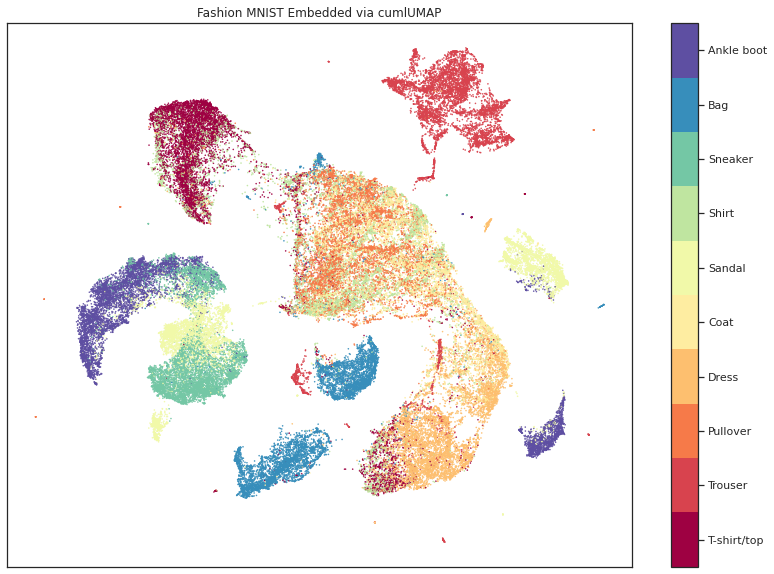

In [23]:
g_embedding_numpy = g_embedding.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via cumlUMAP');



We can also now visualize our data using the `cuxfilter` library.

In [25]:
print('cudf:', cudf.__version__)

# reshaped_df = cudf.DataFrame({'x':g_embedding_numpy[:,1],'y':g_embedding_numpy[:,0]})
reshaped_df = cudf.DataFrame({'x':g_embedding_numpy[:,1],'y':g_embedding_numpy[:,0], 't':target})

print(reshaped_df)

cudf: 0.19.1
              x         y  t
0     -8.504123 -1.507954  9
1     -4.375464  7.401072  0
2      2.452569 -5.322095  0
3      1.936302 -6.157608  3
4      3.010029 -7.550850  0
...         ...       ... ..
69995 -8.316315 -0.365888  9
69996  3.237646  8.325624  1
69997 -0.223979 -5.794967  8
69998  3.289263  9.712934  1
69999 -4.527849 -1.671841  5

[70000 rows x 3 columns]


In [31]:
cux_df = cuxfilter.DataFrame.from_dataframe(reshaped_df)

cmap = list(Spectral[9])
cmap.reverse()
# setting pixel_shade_type='linear' to display legend (currently supports only log/linear)Category20c[20]
scatter_chart = cuxfilter.charts.scatter(x='x',y='y', title='Fashion MNIST Embedded via cumlUMAP', aggregate_col='t', aggregate_fn='mean', color_palette=cmap, pixel_shade_type="linear", legend_position="right")
d = cux_df.dashboard([scatter_chart])
scatter_chart.view()

Card(sizing_mode='stretch_both', title='Fashion MNIST E..., width=800)
    [0] Bokeh(Figure)

In [28]:
#Needs to be redone because of timeit loses our variables sometimes

embedding = umap.UMAP(n_neighbors=5, init="spectral").fit_transform(data)
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)


And side-by-side we can see that the separation is very similar between both GPU and CPU versions of UMAP.  Both cluster Ankle Boot, Sneaker, and Sandal together (Green/Yellow/Purple), both separate Trousers and Bags entirely, and both have T-shirts, Shirts, Coats, etc. all mixed toether.

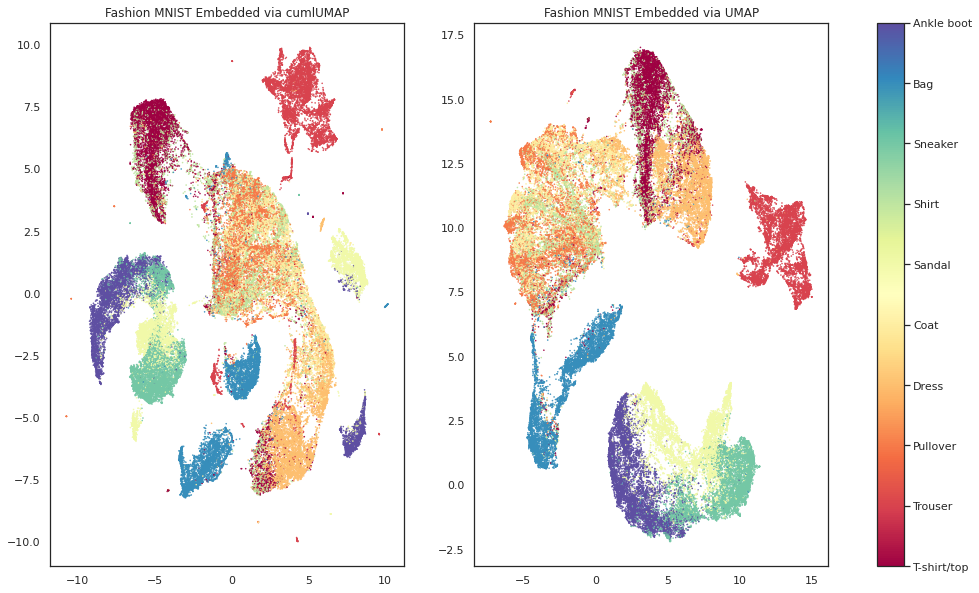

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
im = ax[1].scatter(embedding[:,1], embedding[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
ax[0].set_title('Fashion MNIST Embedded via cumlUMAP');
ax[1].set_title('Fashion MNIST Embedded via UMAP');

fig.subplots_adjust(right=0.8)
cax,kw = mpl.colorbar.make_axes([a for a in ax.flat])
cbar = plt.colorbar(im, cax=cax, **kw)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

Additionally, we can also quanititaviely compare the perfomance of `cumlUMAP` (GPU UMAP) to the reference/original implementation (CPU UMAP) using the [trustworthiness score](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.trustworthiness.html).  From the docstring:

> Trustworthiness expresses to what extent the local structure is retained.  The trustworthiness is within [0, 1].


Like `t-SNE`, UMAP tries to capture both global and local structure and thus, we can apply the `trustworthiness` of the `embedding/g_embedding` data against the original input.  With a higher score we are demonstrating that the algorithm does a better and better job of local structure retention.  As [Corey Nolet](https://github.com/cjnolet) notes:
> Algorithms like UMAP aim to preserve local neighborhood structure and so measuring this property (trustworthiness) measures the algorithm's performance.

Scoring ~97% shows the GPU implementation is comparable to the original CPU implementation and the training time was ~9.5X faster